=== ETLE Vehicle Classification CNN ===
Classes: ['gol_1', 'gol_6', 'gol_darurat']
Image size: (128, 128)
Batch size: 8
Epochs: 100
Loading and preprocessing images...
Loading gol_1 images...
Loading gol_6 images...
Loading gol_darurat images...
Loaded 300 images
Image shape: (300, 128, 128, 3)
Class distribution: [100 100 100]
Training set: 192 samples
Validation set: 48 samples
Test set: 60 samples

=== Model Architecture ===
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 65536)             0         
                 

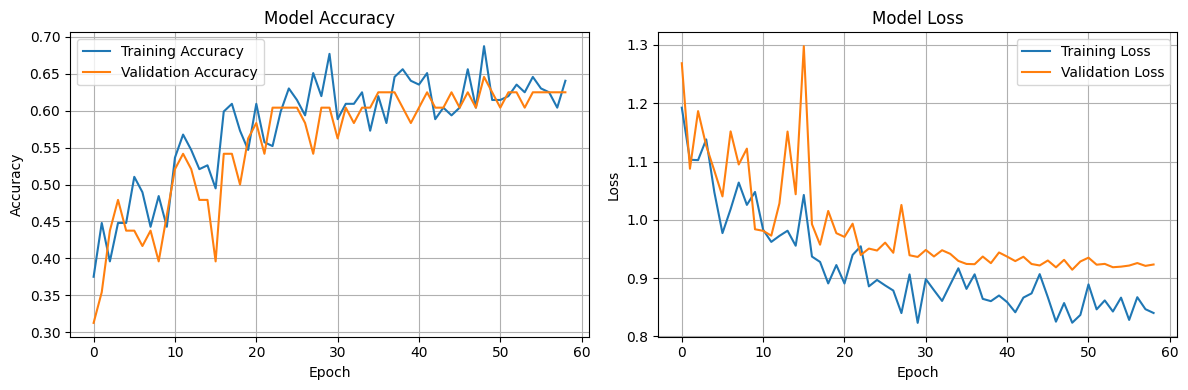

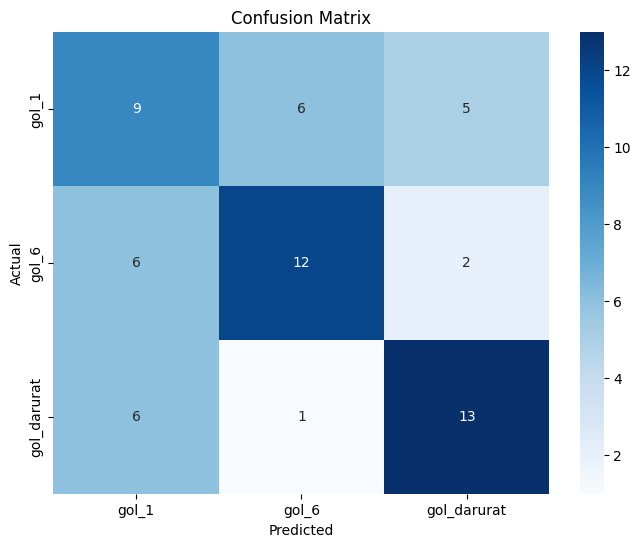


Model saved as 'etle_vehicle_classifier.h5'

=== Sample Predictions ===
Sample 1: True=gol_1, Predicted=gol_6, Confidence=0.617
Sample 2: True=gol_1, Predicted=gol_6, Confidence=0.487
Sample 3: True=gol_darurat, Predicted=gol_6, Confidence=0.455
Sample 4: True=gol_darurat, Predicted=gol_darurat, Confidence=0.409
Sample 5: True=gol_darurat, Predicted=gol_1, Confidence=0.605


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
IMG_SIZE = (128, 128)  # Input image size
BATCH_SIZE = 8
EPOCHS = 100
LEARNING_RATE = 0.0001

# Data paths
BASE_DIR = r"D:\school\uni\sem 4\ai\tugas-akhir-ai\scraped-data"
CLASS_DIRS = {
    'gol_1': os.path.join(BASE_DIR, 'gol_1'),
    'gol_6': os.path.join(BASE_DIR, 'gol_6'),
    'gol_darurat': os.path.join(BASE_DIR, 'gol_darurat')
}

# Class mapping
CLASS_NAMES = ['gol_1', 'gol_6', 'gol_darurat']
NUM_CLASSES = len(CLASS_NAMES)

def load_and_preprocess_data():
    """Load images and create labels"""
    images = []
    labels = []
    print("Loading and preprocessing images...")
    for class_idx, (class_name, class_dir) in enumerate(CLASS_DIRS.items()):
        print(f"Loading {class_name} images...")
        image_files = [f for f in os.listdir(class_dir)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for img_file in image_files:
            try:
                img_path = os.path.join(class_dir, img_file)
                img = Image.open(img_path)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = img.resize(IMG_SIZE)
                img_array = np.array(img) / 255.0
                images.append(img_array)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_file}: {e}")
                continue
    X = np.array(images)
    y = np.array(labels)
    print(f"Loaded {len(X)} images")
    print(f"Image shape: {X.shape}")
    print(f"Class distribution: {np.bincount(y)}")
    return X, y

def create_shallow_cnn():
    model = keras.Sequential([
        layers.Input(shape=(*IMG_SIZE, 3)),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def main():
    print("=== ETLE Vehicle Classification CNN ===")
    print(f"Classes: {CLASS_NAMES}")
    print(f"Image size: {IMG_SIZE}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Epochs: {EPOCHS}")
    print("="*100)
    # Load data
    X, y = load_and_preprocess_data()
    y_categorical = to_categorical(y, NUM_CLASSES)
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_categorical, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train.argmax(axis=1)
    )
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode='nearest'
    )
    # Create model
    model = create_shallow_cnn()
    print("\n=== Model Architecture ===")
    model.summary()
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7
        )
    ]
    # Train model
    print("\n=== Training Model ===")
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    # Evaluate on test set
    print("\n=== Evaluating Model ===")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    # Predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)
    # Classification report
    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    # Plot results
    plot_training_history(history)
    plot_confusion_matrix(y_true, y_pred)
    # Save model
    model.save('etle_vehicle_classifier.h5')
    print("\nModel saved as 'etle_vehicle_classifier.h5'")
    # Sample predictions
    print("\n=== Sample Predictions ===")
    for i in range(min(5, len(X_test))):
        true_class = CLASS_NAMES[y_true[i]]
        pred_class = CLASS_NAMES[y_pred[i]]
        confidence = y_pred_proba[i][y_pred[i]]
        print(f"Sample {i+1}: True={true_class}, Predicted={pred_class}, Confidence={confidence:.3f}")

if __name__ == "__main__":
    main()
